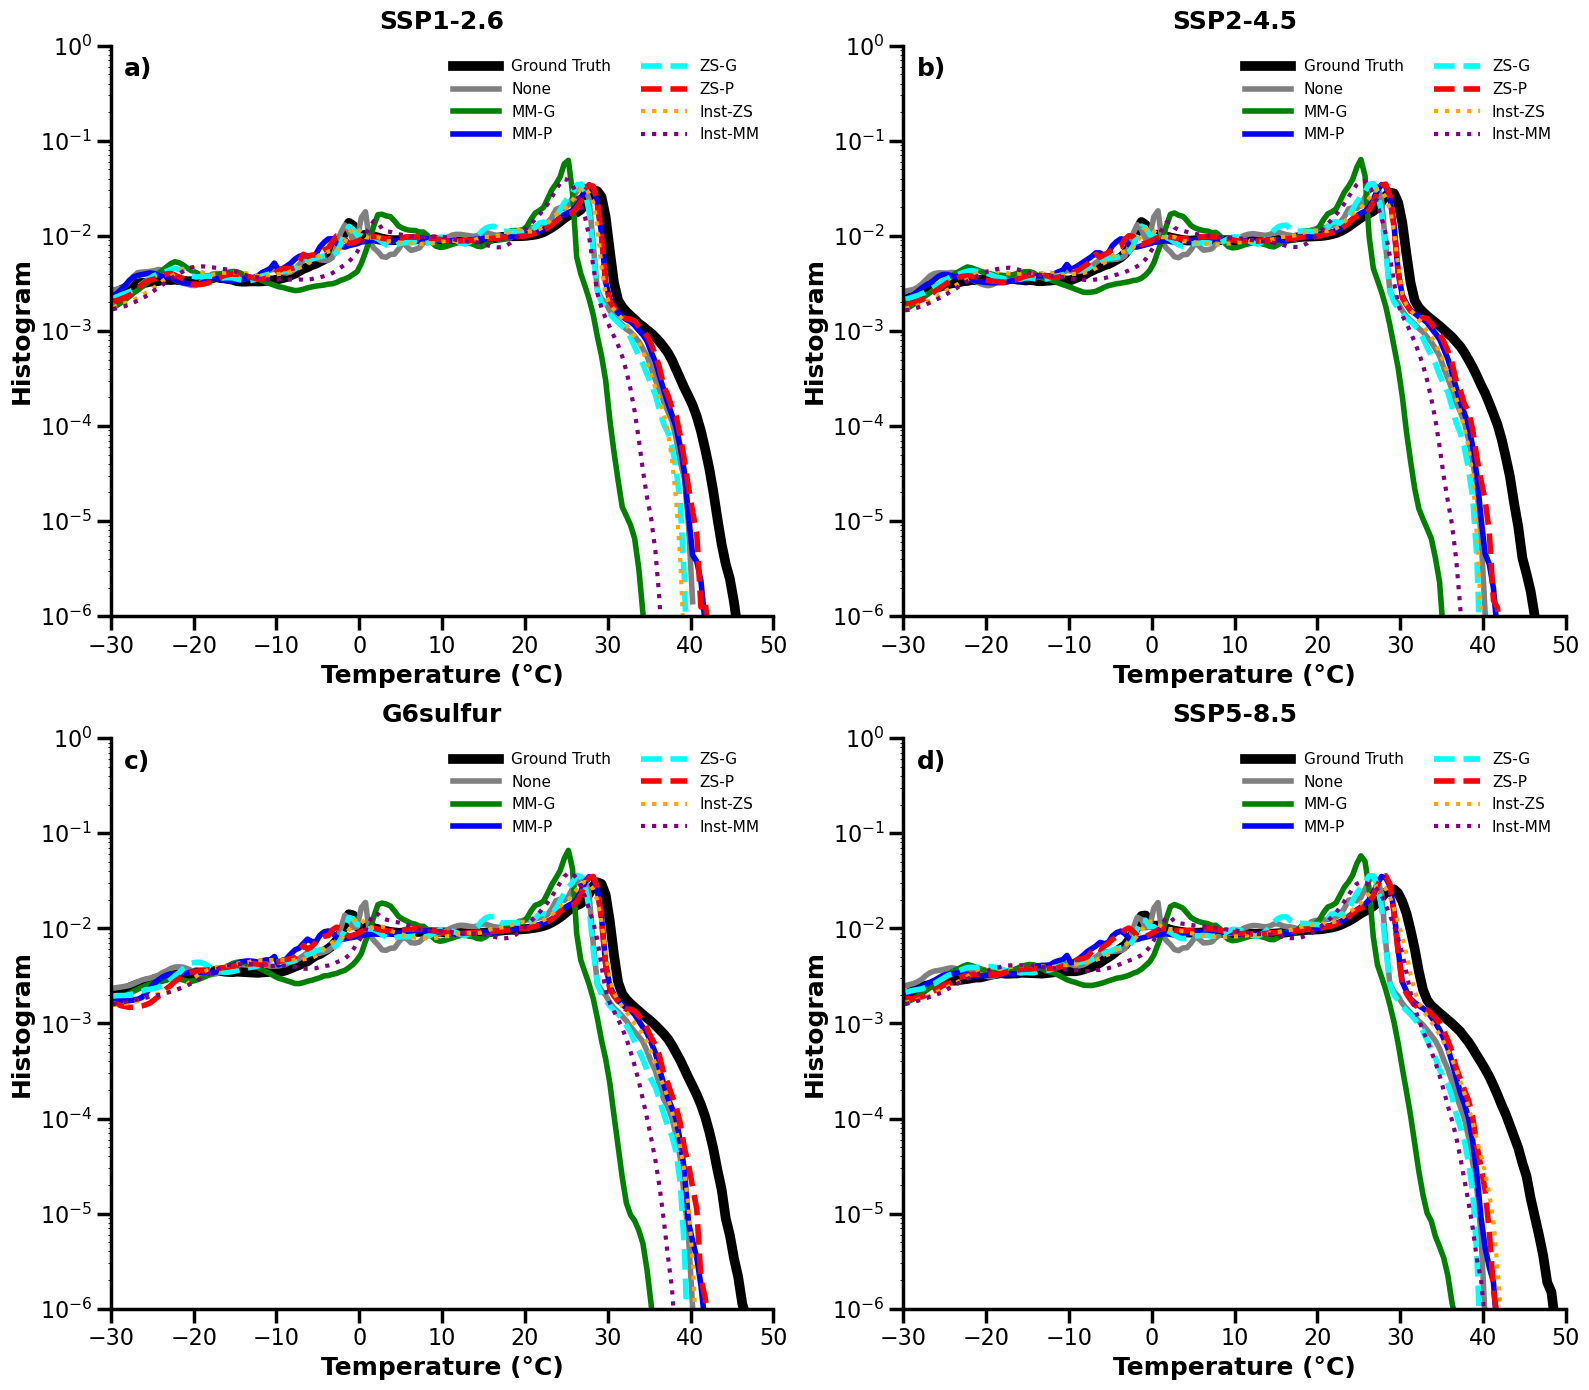

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from pathlib import Path

# Configuration
results_dir = Path("../evaluation_results")
figures_dir = Path("../Figures")

var = 'tas'
scenarios = ['ssp126', 'ssp245', 'g6sulfur', 'ssp585']

scenario_labels = {
    'ssp126': 'SSP1-2.6',
    'ssp245': 'SSP2-4.5',
    'g6sulfur': 'G6sulfur',
    'ssp585': 'SSP5-8.5'
}

# Define plotting order (from bottom to top layer)
plot_order = [
    # Solid lines - plotted first (background)
    'none', 'minmax_global', 'minmax_pixel',
    # Dashed lines - plotted second (middle)
    'zscore_global', 'zscore_pixel',
    # Dotted lines - plotted last (foreground)
    'instance_zscore', 'instance_minmax'
]

model_labels = {
    'groundtruth': 'Ground Truth',
    'none': 'None',
    'minmax_global': 'MM-G',
    'minmax_pixel': 'MM-P',
    'zscore_global': 'ZS-G',
    'zscore_pixel': 'ZS-P',
    'instance_zscore': 'Inst-ZS',
    'instance_minmax': 'Inst-MM'
}

# Colors for each model
model_colors = {
    'groundtruth': 'black',
    'none': 'grey',           
    'minmax_global': 'green',  
    'minmax_pixel': 'blue',   
    'zscore_global': 'cyan', 
    'zscore_pixel': 'red',  
    'instance_zscore': 'orange', 
    'instance_minmax': 'purple'  
}

# Line styles
model_linestyles = {
    'groundtruth': '-',
    'none': '-',
    'minmax_global': '-',
    'minmax_pixel': '-',
    'zscore_global': '--',
    'zscore_pixel': '--',
    'instance_zscore': ':',
    'instance_minmax': ':'
}

# Line widths
model_linewidths = {
    'groundtruth': 7.0,
    'none': 4.0,
    'minmax_global': 4.0,
    'minmax_pixel': 4.0,
    'zscore_global': 4.0,
    'zscore_pixel': 4.0,
    'instance_zscore': 3.0,
    'instance_minmax': 3.0
}

# Alpha values
model_alphas = {
    'groundtruth': 1.0,
    'none': 1.0,
    'minmax_global': 1.0,
    'minmax_pixel': 1.0,
    'zscore_global': 1.0,
    'zscore_pixel': 1.0,
    'instance_zscore': 1.0,
    'instance_minmax': 1.0
}

def compute_histogram_density(data, bins):
    """Compute normalized histogram density for given data and bins"""
    data_flat = data.flatten()
    data_flat = data_flat[~np.isnan(data_flat)]
    
    # Compute histogram with density normalization
    counts, _ = np.histogram(data_flat, bins=bins, density=False)
    
    # Normalize to get probability density
    total = counts.sum()
    if total > 0:
        density = counts / total
    else:
        density = counts
    
    return density

# Create figure with 2x2 subplots
fig, axes = plt.subplots(2, 2, figsize=(16, 14))
axes = axes.flatten()

# Define bins for temperature
tas_bins = np.linspace(-30, 50, 161)  # -30 to 50 °C
tas_bin_centers = (tas_bins[:-1] + tas_bins[1:]) / 2

# Panel labels
panel_labels = ['a)', 'b)', 'c)', 'd)']

# Process each scenario
for idx, scenario in enumerate(scenarios):
    ax = axes[idx]
    
    # Load temperature data
    tas_file = results_dir / f"tas_evaluation_{scenario}.nc"
    
    if not tas_file.exists():
        continue
    
    ds_tas = xr.open_dataset(tas_file)
    
    # Load all data first
    data_dict = {}
    
    # Ground truth
    data_dict['groundtruth'] = ds_tas['groundtruth'].values
    
    # All normalizations
    for norm in ['none', 'minmax_global', 'minmax_pixel', 'zscore_global', 
                 'zscore_pixel', 'instance_zscore', 'instance_minmax']:
        pred_key = f'pred_{norm}'
        if pred_key in ds_tas:
            data_dict[norm] = ds_tas[pred_key].values
    
    # Plot ground truth first
    gt_density = compute_histogram_density(data_dict['groundtruth'], tas_bins)
    mask = gt_density > 0
    ax.plot(tas_bin_centers[mask], gt_density[mask], 
           color=model_colors['groundtruth'],
           linestyle=model_linestyles['groundtruth'],
           linewidth=model_linewidths['groundtruth'],
           alpha=model_alphas['groundtruth'],
           label=model_labels['groundtruth'])
    
    # Plot predictions in specified order
    for model_key in plot_order:
        if model_key not in data_dict:
            continue
        
        density = compute_histogram_density(data_dict[model_key], tas_bins)
        mask = density > 0
        
        ax.plot(tas_bin_centers[mask], density[mask], 
               color=model_colors[model_key],
               linestyle=model_linestyles[model_key],
               linewidth=model_linewidths[model_key],
               alpha=model_alphas[model_key],
               label=model_labels[model_key])
    
    # Add panel label
    ax.text(0.02, 0.98, panel_labels[idx], 
           transform=ax.transAxes,
           fontsize=18, fontweight='bold',
           va='top', ha='left')
    
    # Format axis
    ax.set_yscale('log')
    ax.set_xlim(-30, 50)
    ax.set_ylim(1e-6, 1)
    ax.set_xlabel('Temperature (°C)', fontsize=18, fontweight='bold')
    ax.set_ylabel('Histogram', fontsize=18, fontweight='bold')
    ax.set_title(scenario_labels[scenario], fontsize=18, fontweight='bold', pad=12)
    ax.tick_params(labelsize=16, length=10, width=2.5)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(2.5)
    ax.spines['bottom'].set_linewidth(2.5)
    
    # Add legend to each panel with longer dashed lines
    ax.legend(loc='best', fontsize=11, frameon=False, ncol=2, handlelength=3)

plt.subplots_adjust(hspace=0.6)
plt.tight_layout()

# Save figure
output_file = figures_dir / "histogram_01.png"
plt.savefig(output_file, dpi=300, bbox_inches='tight')

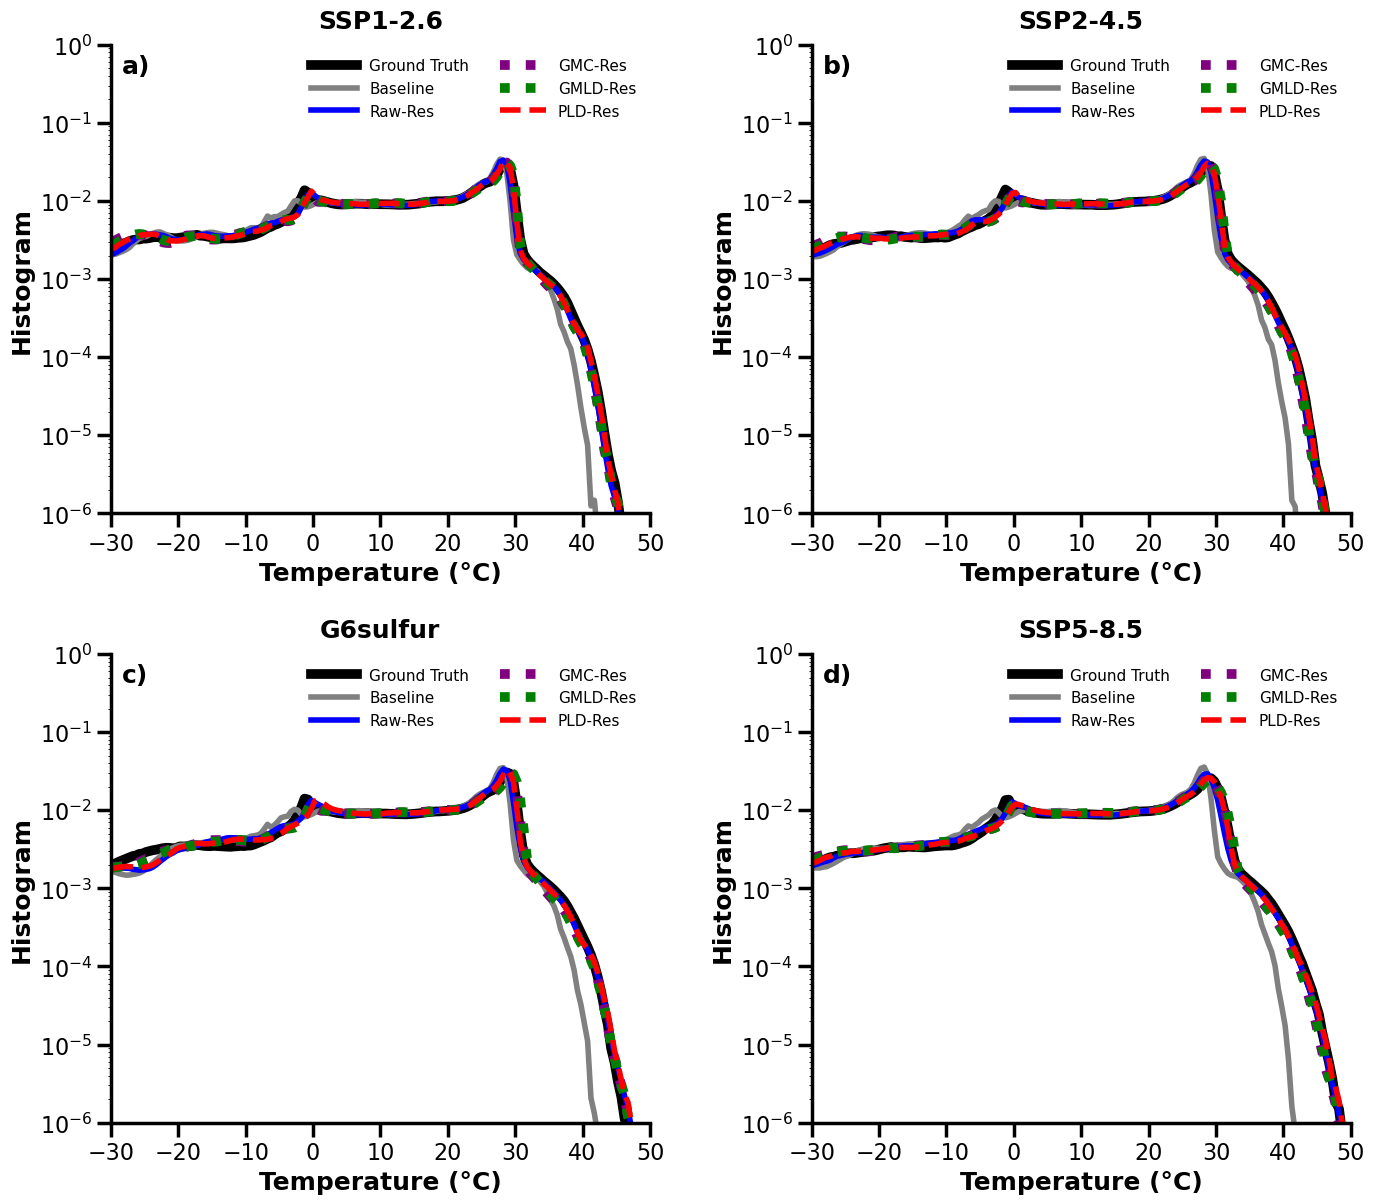

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from pathlib import Path

# Configuration
results_dir = Path("../evaluation_results")
results_residual_dir = Path("../evaluation_results_residual")
figures_dir = Path("../Figures")

var = 'tas'
scenarios = ['ssp126', 'ssp245', 'g6sulfur', 'ssp585']

scenario_labels = {
    'ssp126': 'SSP1-2.6',
    'ssp245': 'SSP2-4.5',
    'g6sulfur': 'G6sulfur',
    'ssp585': 'SSP5-8.5'
}

# Define plotting order (from bottom to top layer)
plot_order = [
    'baseline',
    'raw_residual',
    'gmc_residual',
    'gmld_residual',
    'pld_residual'
]

model_labels = {
    'groundtruth': 'Ground Truth',
    'baseline': 'Baseline',
    'raw_residual': 'Raw-Res',
    'gmc_residual': 'GMC-Res',
    'gmld_residual': 'GMLD-Res',
    'pld_residual': 'PLD-Res'
}

# Colors for each model
model_colors = {
    'groundtruth': 'black',
    'baseline': 'grey',
    'raw_residual': 'blue',
    'gmc_residual': 'purple',
    'gmld_residual': 'green',
    'pld_residual': 'red'
}

# Line styles
model_linestyles = {
    'groundtruth': '-',
    'baseline': '-',
    'raw_residual': '-',
    'gmc_residual': ':',
    'gmld_residual': ':',
    'pld_residual': '--'
}

# Line widths
model_linewidths = {
    'groundtruth': 7.0,
    'baseline': 4.0,
    'raw_residual': 4.0,
    'gmc_residual': 7.0,
    'gmld_residual': 7.0,
    'pld_residual': 4.0
}

# Alpha values
model_alphas = {
    'groundtruth': 1.0,
    'baseline': 1.0,
    'raw_residual': 1.0,
    'gmc_residual': 1.0,
    'gmld_residual': 1.0,
    'pld_residual': 1.0
}

def compute_histogram_density(data, bins):
    """Compute normalized histogram density for given data and bins"""
    data_flat = data.flatten()
    data_flat = data_flat[~np.isnan(data_flat)]
    
    # Compute histogram with density normalization
    counts, _ = np.histogram(data_flat, bins=bins, density=False)
    
    # Normalize to get probability density
    total = counts.sum()
    if total > 0:
        density = counts / total
    else:
        density = counts
    
    return density

# Create figure with 2x2 subplots
fig, axes = plt.subplots(2, 2, figsize=(16, 14))
axes = axes.flatten()

# Define bins for temperature
tas_bins = np.linspace(-30, 50, 161)  # -30 to 50 °C
tas_bin_centers = (tas_bins[:-1] + tas_bins[1:]) / 2

# Panel labels
panel_labels = ['a)', 'b)', 'c)', 'd)']

# Process each scenario
for idx, scenario in enumerate(scenarios):
    ax = axes[idx]
    
    # Load data dictionary
    data_dict = {}
    
    # Load baseline (zscore_pixel)
    baseline_file = results_dir / f"tas_evaluation_{scenario}.nc"
    if baseline_file.exists():
        ds_baseline = xr.open_dataset(baseline_file)
        data_dict['groundtruth'] = ds_baseline['groundtruth'].values
        
        if 'pred_zscore_pixel' in ds_baseline:
            data_dict['baseline'] = ds_baseline['pred_zscore_pixel'].values
    
    # Load residual models
    residual_file = results_residual_dir / f"tas_evaluation_{scenario}.nc"
    if residual_file.exists():
        ds_residual = xr.open_dataset(residual_file)
        
        model_map = {
            'raw_residual': 'pred_raw',
            'gmc_residual': 'pred_gma',
            'gmld_residual': 'pred_gmt',
            'pld_residual': 'pred_grid'
        }
        
        for model_key, data_key in model_map.items():
            if data_key in ds_residual:
                data_dict[model_key] = ds_residual[data_key].values
    
    # Plot ground truth first
    if 'groundtruth' in data_dict:
        gt_density = compute_histogram_density(data_dict['groundtruth'], tas_bins)
        mask = gt_density > 0
        ax.plot(tas_bin_centers[mask], gt_density[mask], 
               color=model_colors['groundtruth'],
               linestyle=model_linestyles['groundtruth'],
               linewidth=model_linewidths['groundtruth'],
               alpha=model_alphas['groundtruth'],
               label=model_labels['groundtruth'])
    
    # Plot models in specified order
    for model_key in plot_order:
        if model_key not in data_dict:
            continue
        
        density = compute_histogram_density(data_dict[model_key], tas_bins)
        mask = density > 0
        
        ax.plot(tas_bin_centers[mask], density[mask], 
               color=model_colors[model_key],
               linestyle=model_linestyles[model_key],
               linewidth=model_linewidths[model_key],
               alpha=model_alphas[model_key],
               label=model_labels[model_key])
    
    # Add panel label
    ax.text(0.02, 0.98, panel_labels[idx], 
           transform=ax.transAxes,
           fontsize=18, fontweight='bold',
           va='top', ha='left')
    
    # Format axis
    ax.set_yscale('log')
    ax.set_xlim(-30, 50)
    ax.set_ylim(1e-6, 1)
    ax.set_xlabel('Temperature (°C)', fontsize=18, fontweight='bold')
    ax.set_ylabel('Histogram', fontsize=18, fontweight='bold')
    ax.set_title(scenario_labels[scenario], fontsize=18, fontweight='bold', pad=12)
    ax.tick_params(labelsize=16, length=10, width=2.5)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(2.5)
    ax.spines['bottom'].set_linewidth(2.5)
    
    # Add legend to each panel with longer dashed lines
    ax.legend(loc='best', fontsize=11, frameon=False, ncol=2, handlelength=3)

plt.subplots_adjust(hspace=0.3, wspace=0.3)

# Save figure
output_file = figures_dir / "histogram_02.png"
plt.savefig(output_file, dpi=300, bbox_inches='tight')